# import, set sampler

In [19]:
import numpy as np
import dwave.inspector
from dwave.system import DWaveSampler
import pickle
import pandas as pd
from pathlib import Path  
from datetime import datetime
import matplotlib.pyplot as plt
import os

In [22]:
f1 = open("../token.txt", "r")
f2 = open("../paid_token.txt", "r")
freetoken=f1.read()
paidtoken=f2.read()

sampler = DWaveSampler(solver=dict(topology__type='zephyr'),token=freetoken)
# sampler = DWaveSampler(solver=dict(topology__type='zephyr'),token=paidtoken)

print("QPU {} was selected.".format(sampler.solver.name))

QPU Advantage2_prototype1.1 was selected.


# get nodes and coups

In [23]:
#get the couplers and nodes classification
with open('nodes_class.pkl', 'rb') as file:
    nodes_class = pickle.load(file)
with open('coups_class.pkl', 'rb') as file:
    coups_class = pickle.load(file)

# functions

In [24]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [25]:
def set_params_array(paramsdict):
    paramsarray = np.array([list(paramsdict.keys()), list(paramsdict.values())])
    return paramsarray

In [26]:
def Reverse(tup):
    newtup=(tup[1],tup[0])
    return newtup

In [27]:
def DocName(jafm,k2,h1,s):
    
    str1="J="+str(jafm)
    str2="h1,k2,s="+str(h1)+","+str(k2)+","+str(s)
    now = datetime.now()
    str3 = now.strftime("%m-%d-%y__%H-%M-%S")
    
    Documentname=str1+'__'+str2+'__'+str3
    
    return Documentname

# anneal offsets

In [31]:
data = pd.read_excel('../data/annealing_schedule.xlsx',  sheet_name='processor-annealing-schedule') 
s_vals = pd.DataFrame(data, columns=['s'])
A_vals = pd.DataFrame(data, columns=['A(s) (GHz)'])
B_vals = pd.DataFrame(data, columns=['B(s) (GHz)'])
cs_vals = pd.DataFrame(data, columns=['C (normalized)'])
first_s = s_vals.to_numpy().flatten()
first_A = A_vals.to_numpy().flatten()
first_B = B_vals.to_numpy().flatten()
first_c = cs_vals.to_numpy().flatten()


In [32]:
new_s = np.linspace(0,1,num = 100*len(first_s))
new_A = np.interp(new_s, first_s, first_A)
new_B = np.interp(new_s, first_s, first_B)
new_c = np.interp(new_s, first_s, first_c)

A2divB = np.divide(new_A**2,new_B)

indices = len(new_A)*np.ones(len(new_A),dtype=np.int8)
# delta_c = np.zeros(len(new_A))
differences = np.zeros(len(new_A))

for i in range(len(new_A)):
    val = find_nearest(A2divB, value = new_A[i])
    differences[i]= A2divB[val] - new_A[i]
    indices[i] = val 
    

In [33]:
hoffset_s = np.divide(new_B,2*new_B[indices])
J22_s = np.divide(new_B,new_B[indices])
J12_s = np.divide(2*new_B,new_B + new_B[indices])
delta_c = new_c[indices] - new_c


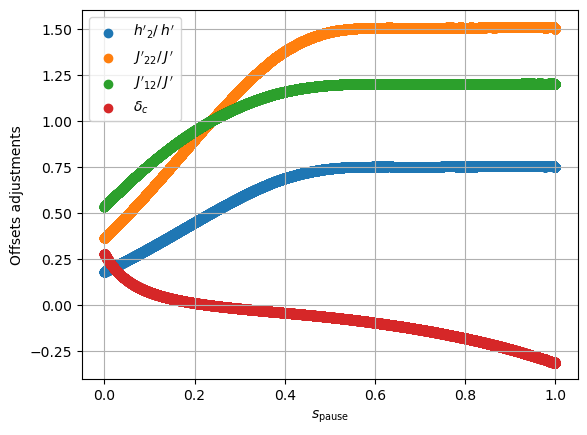

In [34]:
#h value, J_12, J_22
fig, ax = plt.subplots()

ax.scatter(new_s, hoffset_s, label=r"$h'_2/\:h'$")
ax.scatter(new_s, J22_s, label=r"$J'_{22}/\:J'$")
ax.scatter(new_s, J12_s, label=r"$J'_{12}/\:J'$")
ax.scatter(new_s, delta_c, label=r"$\delta_c$")

plt.legend()
#ax.set_yscale('log')
plt.xlabel(r'$s_{\rm pause}$')
plt.ylabel(r'Offsets adjustments')
plt.grid()
plt.show()


# params

In [35]:
splist=np.linspace(0.2,0.7,11)
print(splist)

Nreads = 100
Niter = 100
anneal_time = 1

h = 0

alphaPhi = 2e-6


[0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7 ]


we get the shimming values (flux bias offset) for the h=0, various s_p values.

# Forward anneal

In [ ]:
def qub_mags(hifluxl,Nreads,sstar):
    hdict={}
    hbias=[0]*sampler.properties['num_qubits']
    for j in range(len(hifluxl)):
        hbias[int(newnodes[j])]=hifluxl[j]
        hdict.update({newnodes[j]:0})
    
    ann_sch=[[0.0,0.0],[(100*sstar),sstar],[(100.0*sstar)+10.0,sstar],[(100.0*sstar)+10.0+1.0-sstar,1.0]]
        
    resp = sampler.sample_ising(
        h=hdict,J=,num_reads=Nreads,
        flux_drift_compensation=False,
        flux_biases=hbias,
        anneal_schedule=ann_sch
    )
             
    #number of runs in resp
    Nruns=resp.record.shape[0]
    #make a list of qubits used
    qubitl=[]
    for qubit in resp.variables:
        qubitl.append(qubit)
    #calculate the magnetization of each qubit over all runs
    #and make a magnetization list
    magl=[]
    for i in range(len(qubitl)):
        #list of spins from all runs for qubiti
        spinl=[]
        for run in range(Nruns):
            spin=resp.record[run][0][i]
            spinl.append(spin)
        avgspin=(sum(spinl))/(len(spinl))
        magl.append(avgspin)
        
    qm_ar=np.array([qubitl,magl])
    #this is the magnetization, averaged first over all runs for individual sites,
    #and then averaged over all sites
    avg_m=np.mean(qm_ar[1])
    stdev_m=np.std(qm_ar[1])

    return qm_ar,avg_m,stdev_m

In [ ]:
times_big = []
for i in range(len(hlist)):
    h1val = hlist[i]
    print("h/j=", hoverjlist[i], "h1=",h1val)
       
    jafm = 1.0/np.max(J22_s)
    k2 = -2.0
    
    times = []
    for j in range(len(splist)):
        sp = round(splist[j],2)
        spindex = find_nearest(new_s, sp)
        print("start s_p=", sp)



        #set js
        final_coups={}
        for coup in coups_class:
            if coups_class[coup]=='K2':
                final_coups.update({coup:k2})
            elif coups_class[coup]=='J11':
                final_coups.update({coup:jafm})
            elif coups_class[coup]=='J12':
                final_coups.update({coup:J12_s[spindex]/np.max(J22_s)})
            elif coups_class[coup]=='J22':
                final_coups.update({coup:J22_s[spindex]/np.max(J22_s)})
            else:
                print("error")


        #set hs and anneal offsets
        offsets = [0] * sampler.properties['num_qubits']
        offset = delta_c[spindex]

        hmod_edgeA=0.5
        hmod_edgeB=0.5
        hmod_BSE=1

        final_hs={}
        for node in nodes_class:
            index = node
            #these are onechains. They don't get any hoffset or anneal offset
            if nodes_class[node]=="BUL1":
                final_hs.update({node:h1val})
            elif nodes_class[node]=="BSE1":
                final_hs.update({node: hmod_BSE * h1val})
            elif nodes_class[node]=="EB1":
                final_hs.update({node: hmod_edgeB * h1val})

            #these are twochains. They get hoffsets and anneal offsets
            elif nodes_class[node]=="BUL2":
                final_hs.update({node: hoffset_s[spindex] * h1val})
                offsets[index] = offset
            elif nodes_class[node]=="EA2":
                final_hs.update({node: hmod_edgeA * hoffset_s[spindex] * h1val})
                offsets[index] = offset
            elif nodes_class[node]=="EB2":
                final_hs.update({node: hmod_edgeB * hoffset_s[spindex] * h1val})
                offsets[index] = offset

            else:
                print("error")

            final_nodes=sorted(list(final_hs.keys()))




        anneal_pause_quench_sch = [[0.0, 0.0], [1000*sp, sp], [100 + 1000*sp, sp],
                    [100 + 1000*sp + (1-sp), 1]]

        time_allreps=[]

        for rep in range(Nreps): 

            response =  sampler.sample_ising(
                        h=final_hs,
                        J=final_coups,
                        anneal_schedule=anneal_pause_quench_sch,
                        num_reads=Nreads,
                        anneal_offsets = offsets)

            time = response.info['timing']['qpu_access_time']
            
#             time =  sampler.solver.estimate_qpu_access_time(
#                 num_qubits=len(final_nodes),
#                 anneal_schedule=anneal_pause_quench_sch,
#                 num_reads=Nreads,
#                 answer_mode = "raw")

            time_allreps.append(time)

            folder = Path(
               "/Users/prathunarasimhan/Desktop/APQ extra/raw"
                + "/" + "h1=" + str(h1val) 
                + "/" + "s=" + str(sp))
            folder.mkdir(parents=True, exist_ok=True)


            Name = DocName(jafm, k2, h1val, sp) + "_" + str(rep)
            filepath = Path(folder, Name)



            paramsarray = set_params_array({
                    'jafm': jafm,
                    'k2': k2,
                    'h1': h1val,
                    'Nreads': Nreads,
                    'sp' : sp
                })

            resp = response.record
            np.savez(
            filepath,
            resp=resp,
            paramsarray=paramsarray,
            final_nodes=final_nodes,
            )


        times.append(sum(time_allreps))
        print("s_p=", sp, "time=", sum(time_allreps))
    print("h1=", h1val, "time=", sum(times))
    times_big.append(sum(times))
    print("")
print("")
print("")
print("")
print("anneal pause quench anneal access time", sum(times_big) / 1000000, "seconds", sum(times_big) / 1000000 /60, "minutes")
print("all done")

h/j= 1.25 h1= 1.8900156937577515
start s_p= 0.2
s_p= 0.2 time= 7303808.200000002
start s_p= 0.25
s_p= 0.25 time= 8302584.2
start s_p= 0.3
s_p= 0.3 time= 9301784.200000001
start s_p= 0.35
s_p= 0.35 time= 10300624.200000003
start s_p= 0.4
s_p= 0.4 time= 11299824.200000003
start s_p= 0.45
s_p= 0.45 time= 12298616.200000007
start s_p= 0.5
s_p= 0.5 time= 13297824.200000007
start s_p= 0.55
s_p= 0.55 time= 14296608.200000001
start s_p= 0.6
s_p= 0.6 time= 15295808.200000001
start s_p= 0.65
s_p= 0.65 time= 16294608.200000001
start s_p= 0.7
s_p= 0.7 time= 17293808.2
h1= 1.8900156937577515 time= 135285898.20000002

h/j= 1.75 h1= 2.646021971260852
start s_p= 0.2
s_p= 0.2 time= 7303792.200000002
start s_p= 0.25
s_p= 0.25 time= 8302592.200000002
start s_p= 0.3
s_p= 0.3 time= 9301744.200000001
start s_p= 0.35
s_p= 0.35 time= 10300544.200000003
start s_p= 0.4
s_p= 0.4 time= 11299792.2
start s_p= 0.45
s_p= 0.45 time= 12298608.200000001
start s_p= 0.5
s_p= 0.5 time= 13297824.200000007
start s_p= 0.55
s_